# EOF Analysis of NEMO surface tracers

***

In [55]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from cmocean import cm
from datetime import datetime, timedelta
from scipy import signal
from scipy.fftpack import fft, fftshift
from tqdm import tqdm_notebook as tqdm
from salishsea_tools import viz_tools, places

%matplotlib inline

***

## Load data

Daterange and boilerplate netCDF objects

In [3]:
# Daterange
daterange = [datetime(2015, 1, 15), datetime(2019, 1, 1)]

In [4]:
# Load NEMO netCDF files (concatentated using NCO)
ptrc = xr.open_dataset('/ocean/bmoorema/research/MEOPAR/analysis-ben/data/SalishSeaCast/SalishSea_1h_20150101_20181231_ptrc_T.nc')
mask = xr.open_dataset('/data/bmoorema/MEOPAR/grid/mesh_mask201702.nc')
coords = xr.open_dataset('/data/bmoorema/MEOPAR/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)
tindex = [abs(ptrc.time_counter.values.astype('datetime64[s]').astype(datetime)-date).argmin()+1 for date in daterange]

# Load HRDPS netCDF files from ERDDAP at Sentry Shoal
j, i = places.PLACES['Sentry Shoal']['GEM2.5 grid ji']
HRDPS = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1')
HRDPS = HRDPS.sel(time=slice(*daterange)).isel(gridY=j, gridX=i)

Load NEMO tracers into memory and flatten (in prep for PCA)

In [5]:
# Characterize subgrid (ptrc subdomain from NEMO NCO processing)
xrange, yrange, skip = [115, 361], [310, 789], 5
gridx, gridy = np.meshgrid(ptrc.x[::skip], ptrc.y[::skip])
shape = gridx.shape
npoints = np.prod(shape)

# Construct flattened variables
tmask = mask.tmask[0, 0, slice(*yrange), slice(*xrange)].values[::skip, ::skip].reshape(npoints).astype(bool)
gridx = gridx.reshape(npoints)[tmask]
gridy = gridy.reshape(npoints)[tmask]
nitrate = ptrc.nitrate[:, 0, ...].values[:, ::skip, ::skip].reshape(-1, npoints)[:, tmask]

Load HRDPS from ERDDAP into memory in ~6 month (4341 h) chunks

In [6]:
# Load netCDF data from ERDDAP in 6 month chunks
time, u, v = np.empty(0), np.empty(0), np.empty(0)
hours, chunk = int(np.diff(daterange)[0].total_seconds() / 3600), 4341
for hour in tqdm(range(0, hours, chunk)):
    dateslice = slice(*[daterange[0] + timedelta(hours=h) for h in (hour, hour + chunk - 1)])
    time = np.concatenate((time, HRDPS.time.sel(time=dateslice).values.astype('datetime64[s]').astype(datetime)))
    u = np.concatenate((u, HRDPS.u_wind.sel(time=dateslice).values))
    v = np.concatenate((v, HRDPS.v_wind.sel(time=dateslice).values))

# Process wind
mag = np.sqrt(u**2 + v**2)
angle = 180 * (1 - (np.arctan2(v, u) + np.arctan(2)) / np.pi) + 22
mag_axis = mag * np.cos(np.deg2rad(angle))

***

## Filtering

### Nitrate power spectral density (PSD)

First look at the surface nitrate PSD at selected coastal stations.

In [7]:
# Define coastal stations
stations = [
    {'name': 'Campbell River', 'loc': (720, 125), 'c': 'r'},
    {'name': 'Boundary Bay'  , 'loc': (360, 305), 'c': 'darkorange'},
    {'name': 'Qualicum'      , 'loc': (560, 165), 'c': 'gold'},
    {'name': 'Sunshine Coast', 'loc': (535, 250), 'c': 'darkslategray'},
]

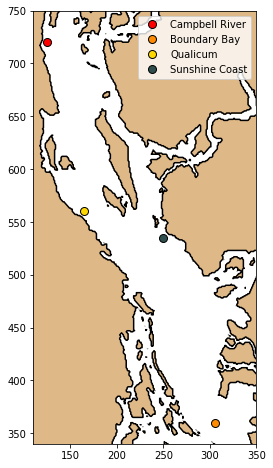

In [8]:
# Plot coastal stations
fig, ax = plt.subplots(figsize=(4, 8))
ax.set_xlim([110, 350])
ax.set_ylim([340, 750])
viz_tools.set_aspect(ax)
for attr, color in zip(['contourf', 'contour'], ['Burlywood', 'k']):
    getattr(ax, attr)(mask.x, mask.y, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors=color)
for station in stations:
    ax.plot(*station['loc'][::-1], 'ko', markerfacecolor=station['c'], markersize=8, label=station['name'])
ax.legend()
plt.show()

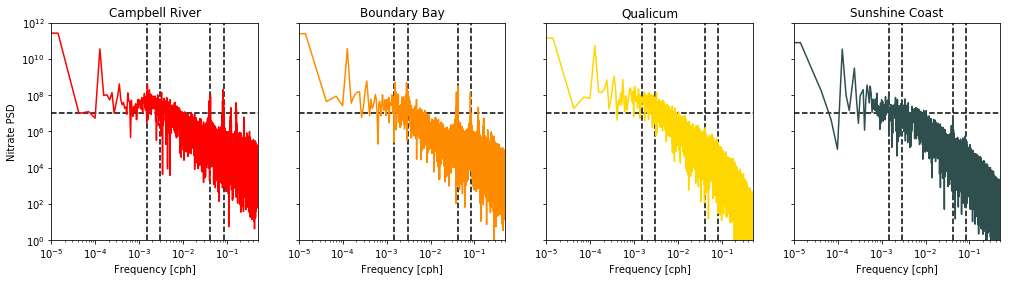

In [9]:
# Plot surface nitrate PSD at coastal stations
xlim, ylim, n = [1e-5, 1/2], [1, 1e12], nitrate.shape[0]
freq = np.linspace(-1/2, 1/2, n)
peaks = [12, 24, 24*14, 24*28]
fig, axs = plt.subplots(1, 4, figsize=(17, 4))
for ax, station in zip(axs, stations):
    ax.plot(xlim, [1e7, 1e7], 'k--')
    for peak in peaks:
        ax.plot([1 / peak, 1 / peak], ylim, 'k--')
    index = ((gridy == station['loc'][0] - yrange[0]) & (gridx == station['loc'][1] - xrange[0])).argmax()
    PSD = abs(fftshift(fft(nitrate[:, index])))**2
    ax.plot(freq, PSD, '-', color=station['c'])
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_xlabel('Frequency [cph]')
    ax.set_title(station['name'])
    if station['name'] == 'Campbell River': ax.set_ylabel('Nitrate PSD')
    else: ax.yaxis.set_ticklabels('')

***

### Attenuation spectra of FIR moving average filter windows

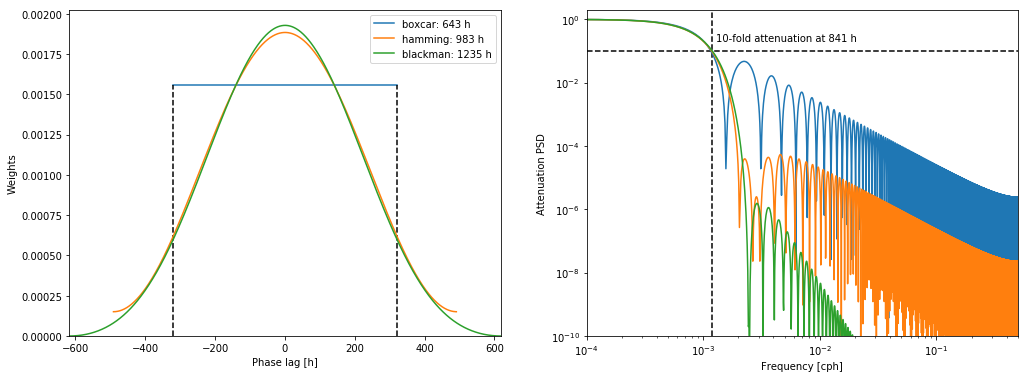

In [10]:
# Define parameters
cutoff = 841
freq = np.linspace(-1/2, 1/2, n)
W = (cutoff / 2 * np.array([0.765, 1.168, 1.468])).astype('int') * 2 + 1
order = 10**(np.floor(np.log10(1 / cutoff)) - 1)

# Make plots
fig, axs = plt.subplots(1, 2, figsize=(17, 6))
lims = [(-max(W)/2, max(W)/2, 0, 2.5/max(W)), (order, 1/2, 1e-10, 2)]
labels = [(f'Phase lag [h]', 'Weights'), ('Frequency [cph]', 'Attenuation PSD')]
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].plot([1/cutoff, 1/cutoff], lims[1][2:], 'k--')
axs[1].plot(lims[1][:2], [0.1, 0.1], 'k--')
axs[1].text(1/cutoff + order, 0.2, f'10-fold attenuation at {cutoff} h')
for ax, lim, label in zip(axs, lims, labels):
    ax.set_xlim(lim[:2])
    ax.set_ylim(lim[2:])
    ax.set_xlabel(label[0])
    ax.set_ylabel(label[1])

# Plot filters
for window_type, w in zip(['boxcar', 'hamming', 'blackman'], W):
    w2 = (w - 1) / 2
    window = signal.get_window(window_type, w)
    window = window / sum(window)
    PSD = abs(fftshift(fft(window, n)))**2
    axs[0].plot(np.linspace(-w2, w2, w), window, label=f'{window_type}: {np.round(w):.0f} h')
    axs[1].plot(freq, PSD)
    if window_type is 'boxcar':
        [axs[0].plot([fac*w2, fac*w2], [0, window[0]], 'k--') for fac in [-1, 1]]

axs[0].legend()
plt.show()

***

### Apply selected filter windows to surface nitrate

Since we are subtracting the lowpass filter data, we want to preserve as much high frequency signal as possible (i.e. small sidelobes are more important than steep cutoff). We thus choose the Blackman filter.

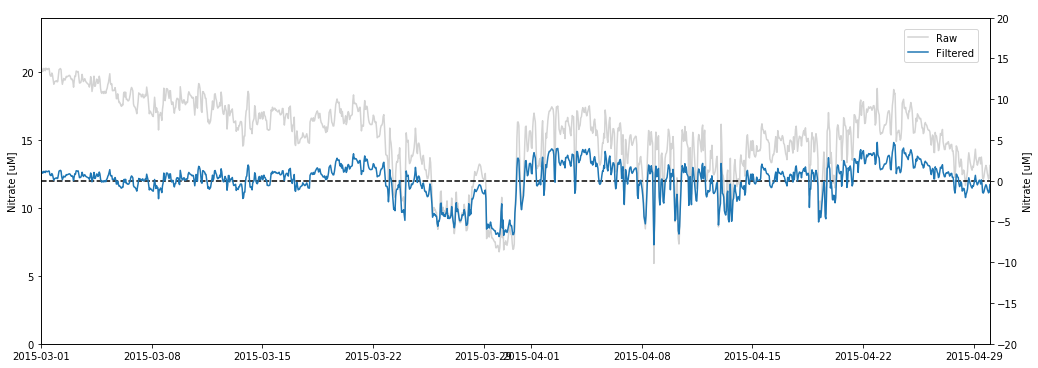

In [12]:
# Make figure
xlim = [datetime(2015, 3, 1), datetime(2015, 4, 30)]
fig, ax = plt.subplots(figsize=(17, 6))
ax.plot(ptrc.time_counter.values, nitrate[:, 0], '-', color='lightgray', label='Raw')
ax.set_xlim(xlim)
ax.set_ylim([0, 24])
ax.set_ylabel('Nitrate [uM]')
ax2 = ax.twinx()
ax2.plot(xlim, [0, 0], 'k--')
ax2.set_ylim([-20, 20])
ax2.set_ylabel('Nitrate [uM]')

# Calculate bandpass as difference between windows
window_type, w = 'blackman', 1235
nitrate_highpass = {}
window = signal.get_window(window_type, w)
window = window / sum(window)
nitrate_highpass[window_type] = np.empty(nitrate.shape)
for i, loc in zip(tqdm(range(nitrate.shape[1])), nitrate.T):
    nitrate_highpass[window_type][:, i] = loc - signal.convolve(loc, window, mode='same')
ax2.plot(ptrc.time_counter.values, nitrate_highpass[window_type][:, 0], label='Filtered')
fig.legend(loc=(0.87, 0.83))
plt.show()

***

## Calculate EOF

In [13]:
def varimax(A, maxiter=30, tol=1e-5):
    """From Horst 1965
    with modifications from Ben FrantzDale on Wikipedia talkpage
    https://en.wikipedia.org/wiki/Talk:Varimax_rotation
    """
    
    n, p = A.shape
    H = np.eye(p)
    d = 0
    convergence = []
    for i in tqdm(range(maxiter)):
        d_old = d
        B = A.dot(H)  # -------------------------------------------------------- 18.4.5
        beta = B * B * B - B.dot(np.diag(np.diag(B.T.dot(B)))) / n  # ---------- 18.4.1
        C = A.T.dot(beta)  # --------------------------------------------------- 18.4.2
        u, s, vh = np.linalg.svd(C)  # -- 18.4.3 (modified by Ben FrantzDale (Wikipedia) to use SVD)
        H = u.dot(vh)  # ---------------- 18.4.4 (modified by Ben FrantzDale (Wikipedia))
        d = sum(s)
        convergence.append(d)
        if d_old != 0 and d/d_old < 1 + tol: break
    return H, convergence

In [14]:
# EOF analysis
EOF = {}
A_prime, sqrtL, E_T = np.linalg.svd(nitrate_highpass['blackman'][slice(*tindex), :], full_matrices=False)
EOF['A'] = A_prime.dot(np.diag(sqrtL))
A2 = EOF['A'] * EOF['A']
EOF['var'] = A2.sum(axis=0) / A2.sum()
EOF['E'] = E_T.T

In [15]:
# Get varimax rotation matrix
R, convergence = varimax(EOF['A'])

# Rotate matrices
EOF['B'] = EOF['A'].dot(R)
B2 = EOF['B'] * EOF['B']
EOF['var_rot'] = B2.sum(axis=0) / B2.sum()
EOF['U'] = EOF['E'].dot(R)

***

## Plot EOFs

In [16]:
def plot_EOF(EOF):
    """Plot EOFs
    """
    
    # Make figure and plotting params
    fig, axs = plt.subplots(4, 5, figsize=(17, 20), gridspec_kw={'hspace': 0.05, 'height_ratios': [1, 3, 1, 3]})
    plotx, ploty = mask.x[slice(*xrange, 5)], mask.y[slice(*yrange, 5)]
    xlim, ylim = [1e-4, 1/2], [1, 1e11]
    freq = np.linspace(-1/2, 1/2, EOF['A'].shape[0])
    
    # Plot PCs
    for row, PC, var in zip([0, 2], ['A', 'B'], ['var', 'var_rot']):
        for ax, mode in zip(axs[row, :], range(5)):
            for peak in [24, 24*12]: ax.plot([1/peak, 1/peak], ylim, 'c--')
            PSD = abs(fftshift(fft(EOF[PC][:, mode])))**2
            ax.plot(freq, PSD, 'k-')
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.text(0.02, 0.05, f'{EOF[var][mode]*100:.01f}% variance', transform=ax.transAxes)
            if mode == 0: ax.set_ylabel('PC PSD')
            else: ax.yaxis.set_ticklabels('')
            if row == 0: ax.set_title(f'Mode {mode}')

    # Plot EOFs
    for row, eof in zip([1, 3], ['E', 'U']):
        for ax, mode in zip(axs[row, :], range(5)):
            gridded = np.zeros(ptrc.nav_lon.shape)
            for y, x, val in zip(gridy, gridx, EOF[eof][:, mode]): gridded[y, x] = val
            ax.contourf(plotx, ploty, gridded[::skip, ::skip], levels=np.arange(-0.1, 0.101, 0.001), cmap=cm.balance, extend='both')
            ax.contourf(mask.x, mask.y, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='Burlywood')
            ax.contour(mask.x, mask.y, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
            viz_tools.set_aspect(ax)
            ax.set_xlim(xrange)
            ax.set_ylim(yrange)
            if mode != 0: ax.yaxis.set_ticklabels('')

    # Add final labels
    for ypos, text in zip([0.43, 0.81], ['Rotated', 'Non-rotated']):
        fig.text(0.128, ypos, text, fontdict={'size': 16, 'weight': 'bold'})

***

### 7 day cutoff

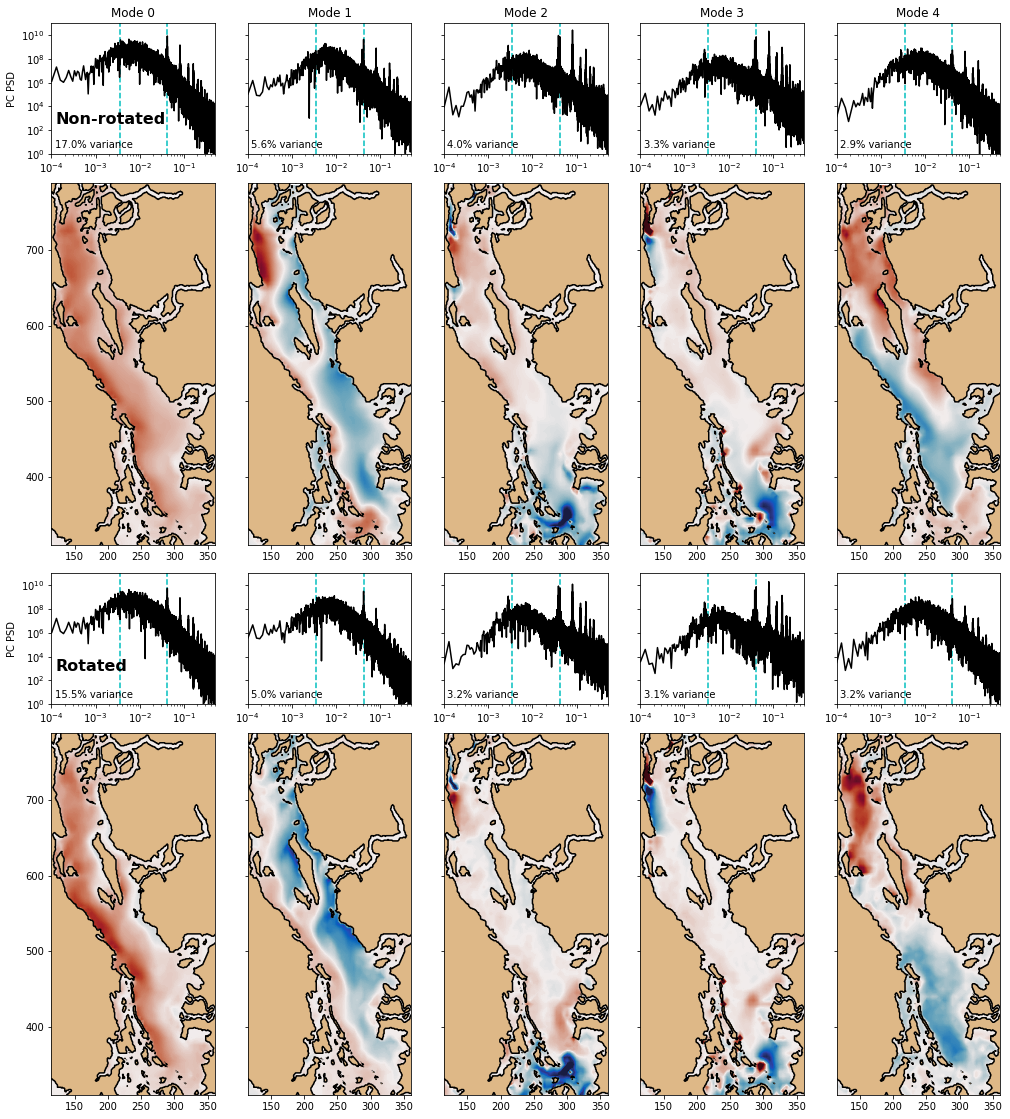

In [26]:
# 7 day cutoff
plot_EOF(EOF)

### 14 day cutoff

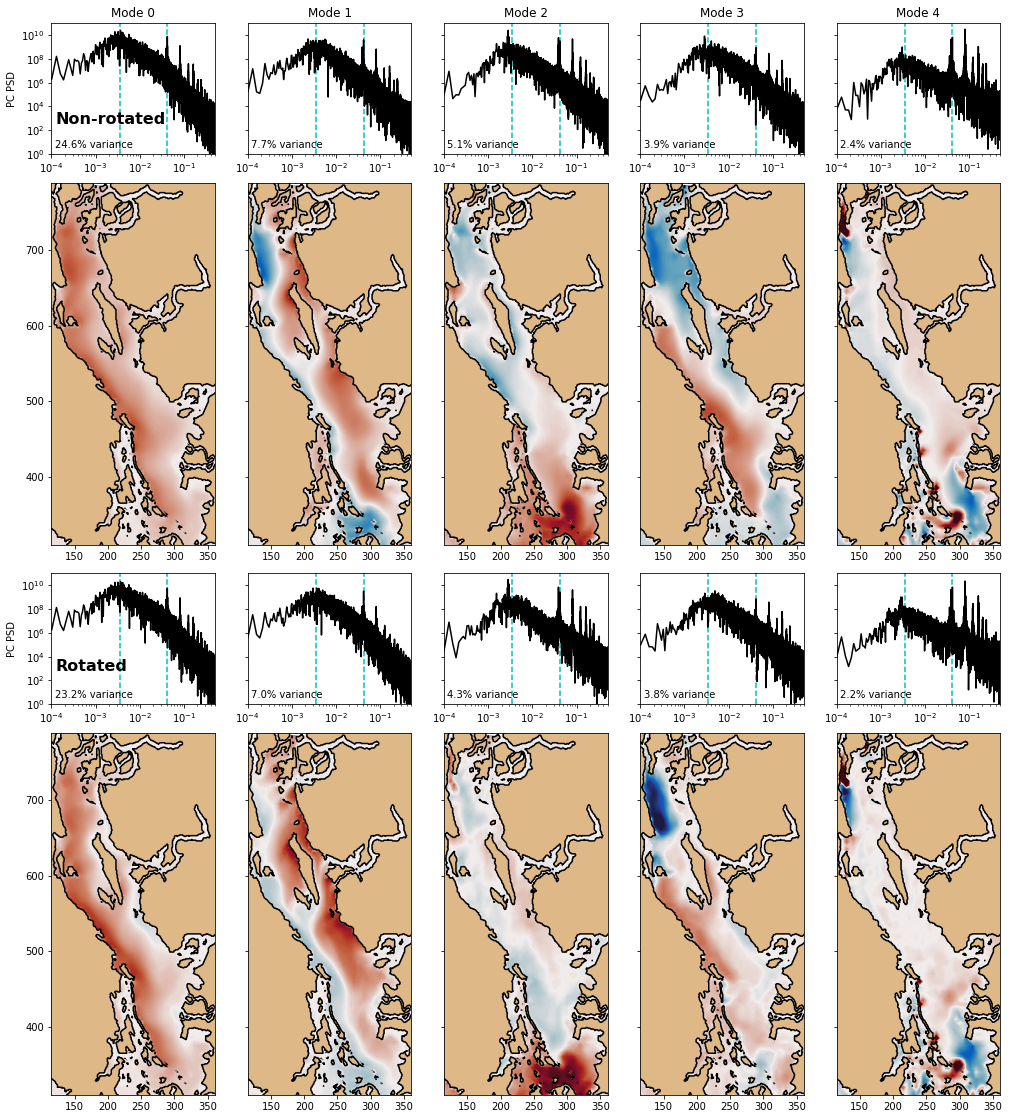

In [31]:
# 14 day cutoff
plot_EOF(EOF)

### 21 day cutoff

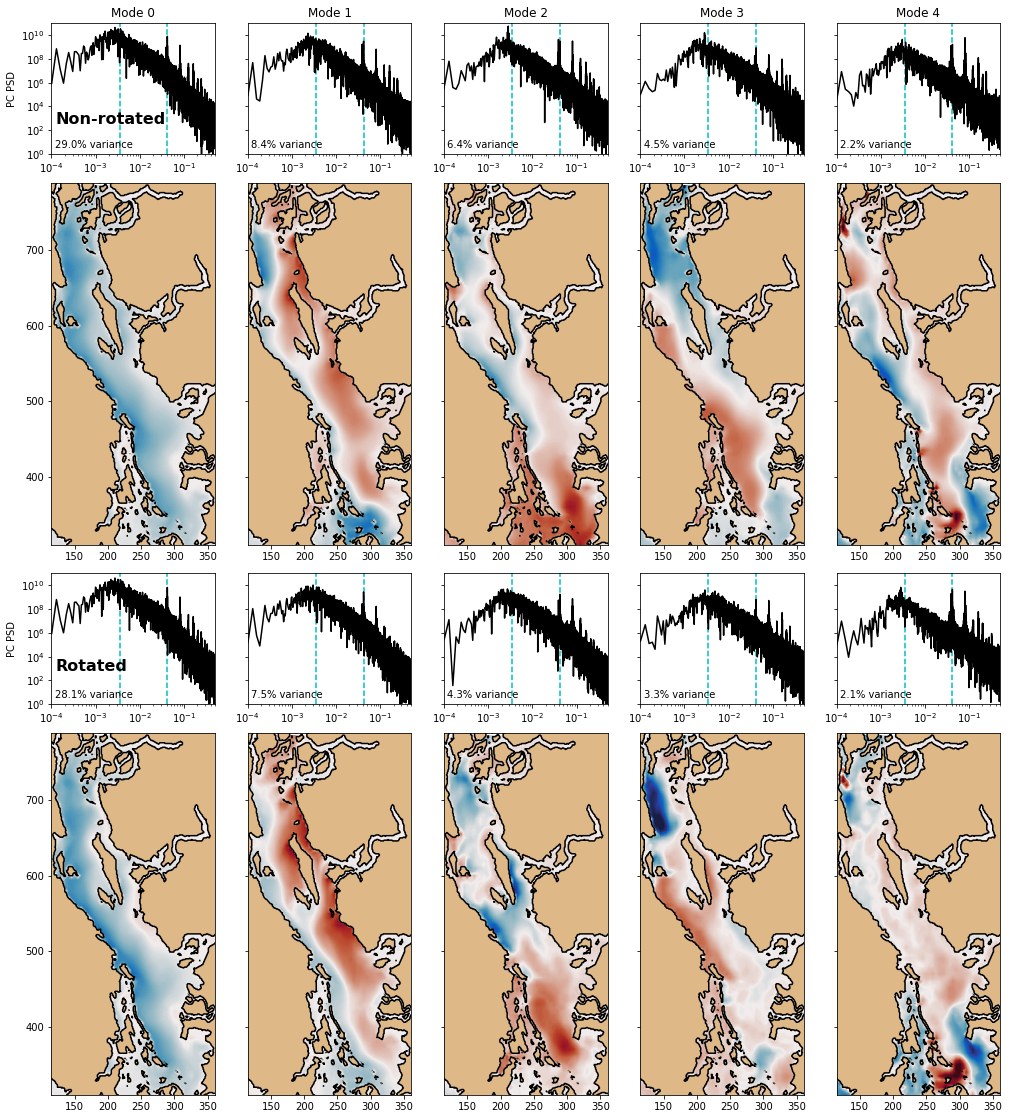

In [36]:
# 21 day cutoff
plot_EOF(EOF)

### 28 day cutoff

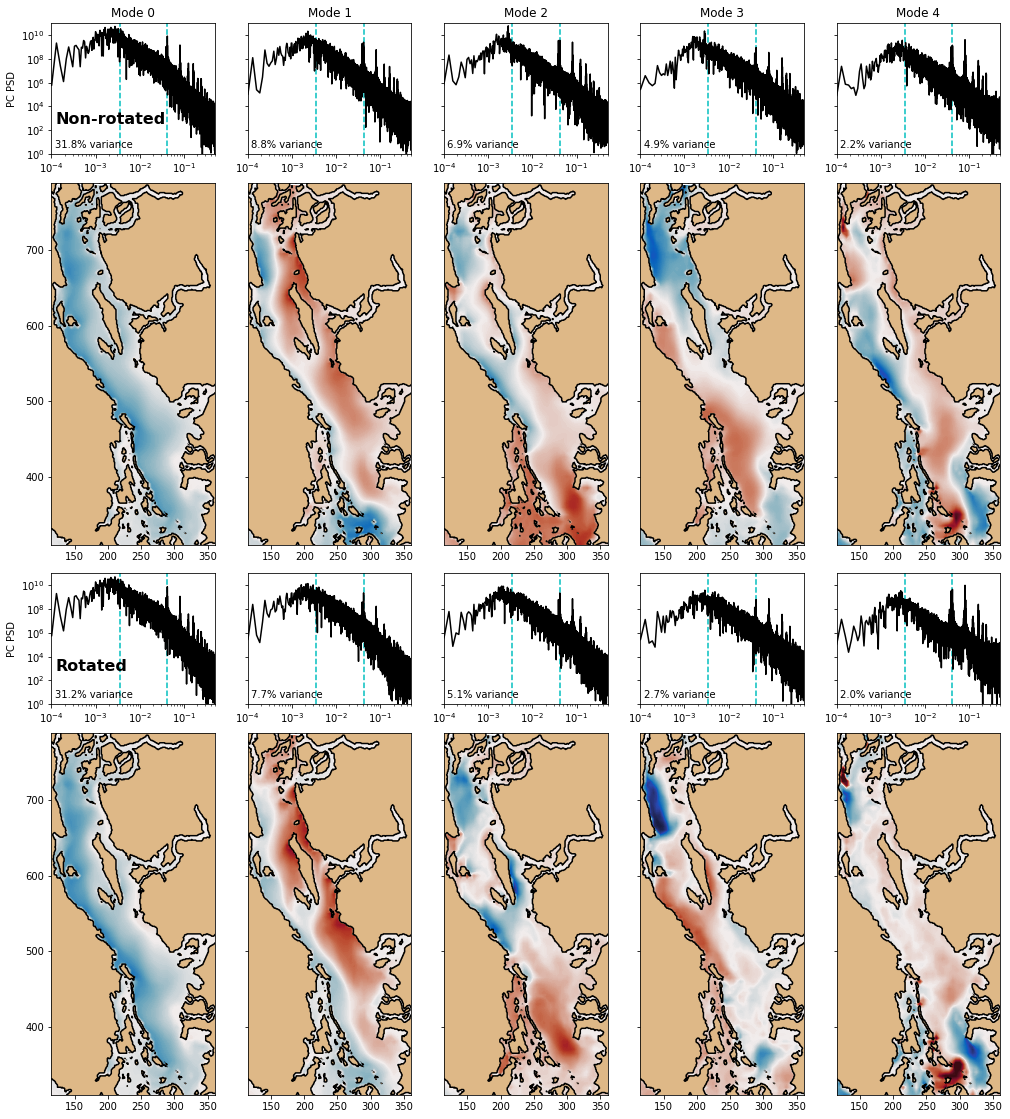

In [41]:
# 28 day cutoff
plot_EOF(EOF)

### 35 day cutoff

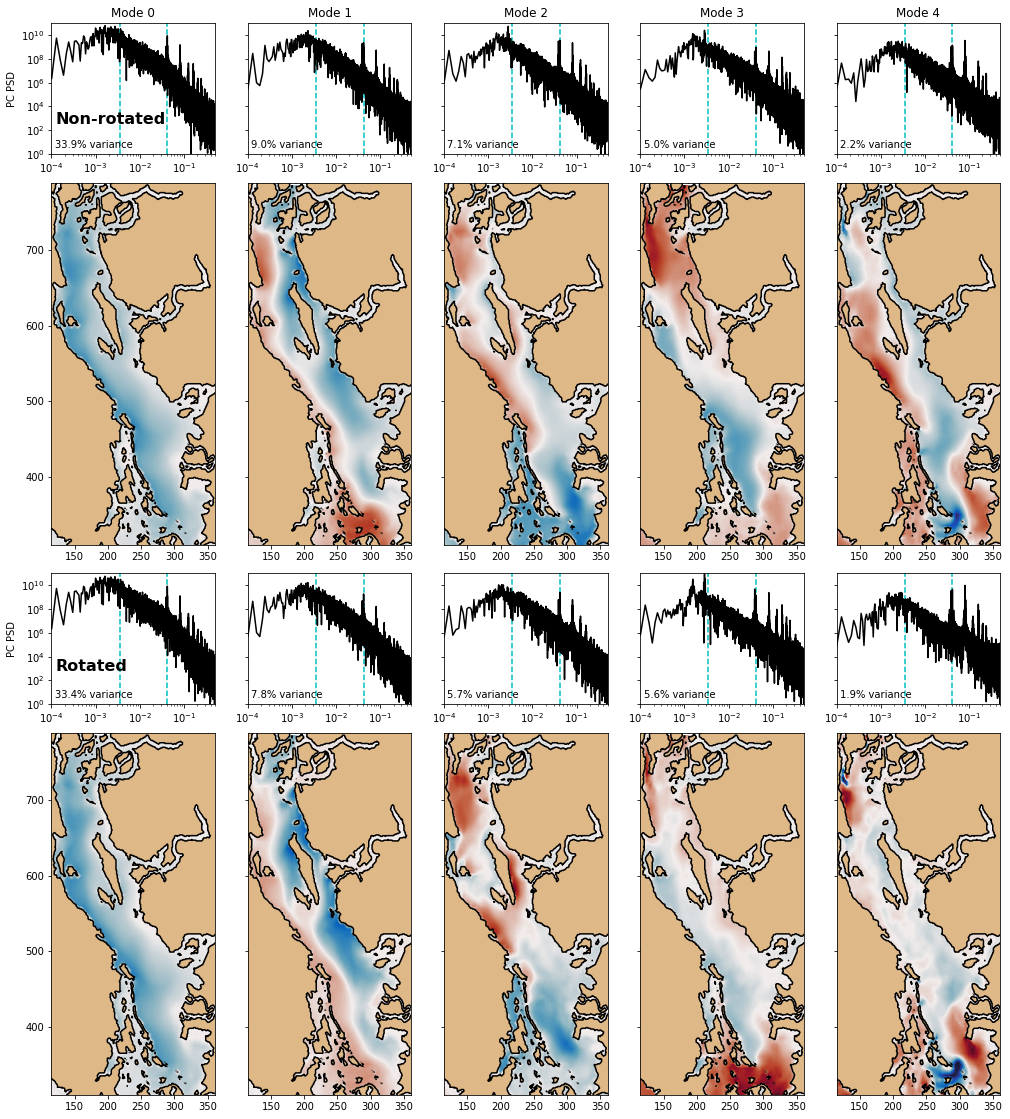

In [18]:
# 35 day cutoff
plot_EOF(EOF)

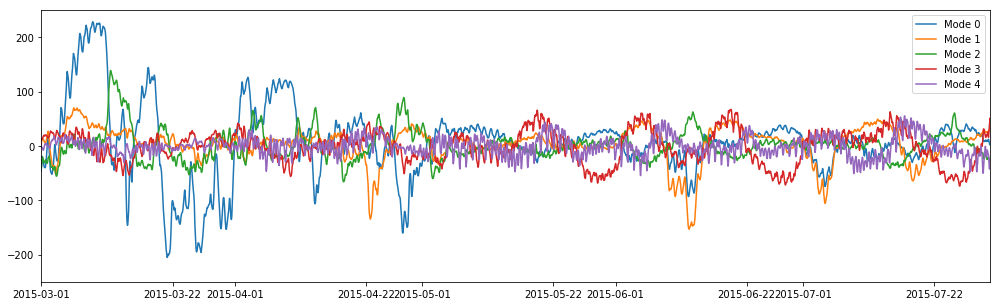

In [32]:
fig, ax = plt.subplots(figsize=(17, 5))

for mode in range(5):
    ax.plot(time, EOF['B'][:, mode], label=f'Mode {mode}')
    
ax.set_xlim(['2015 Mar 1', '2015 Jul 31'])
ax.set_ylim([-250, 250])
ax.legend()

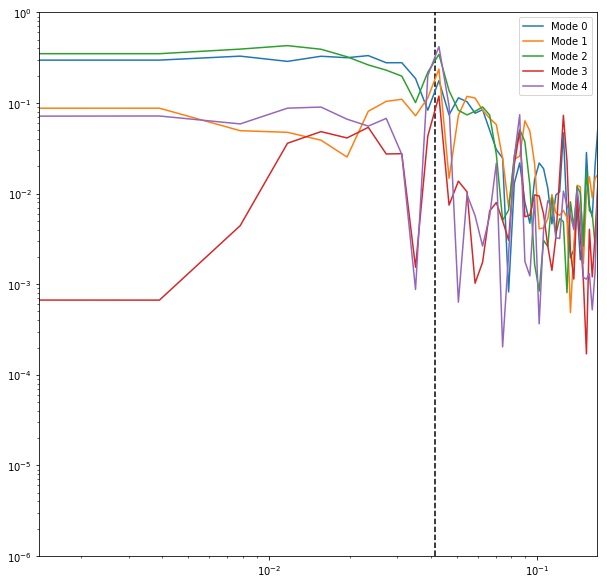

In [72]:
ylim = [1e-6, 1]

fig, ax = plt.subplots(figsize=(10, 10))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(ylim)
ax.set_xlim([1/(24*30), 1/6])
ax.plot([1/24, 1/24], ylim, 'k--')

for mode in range(5):
    f, Cxy = signal.coherence(mag_axis, EOF['B'][:, mode], fs=1/3600)
    ax.plot(f*3600, Cxy, label=f'Mode {mode}')
    
ax.legend()

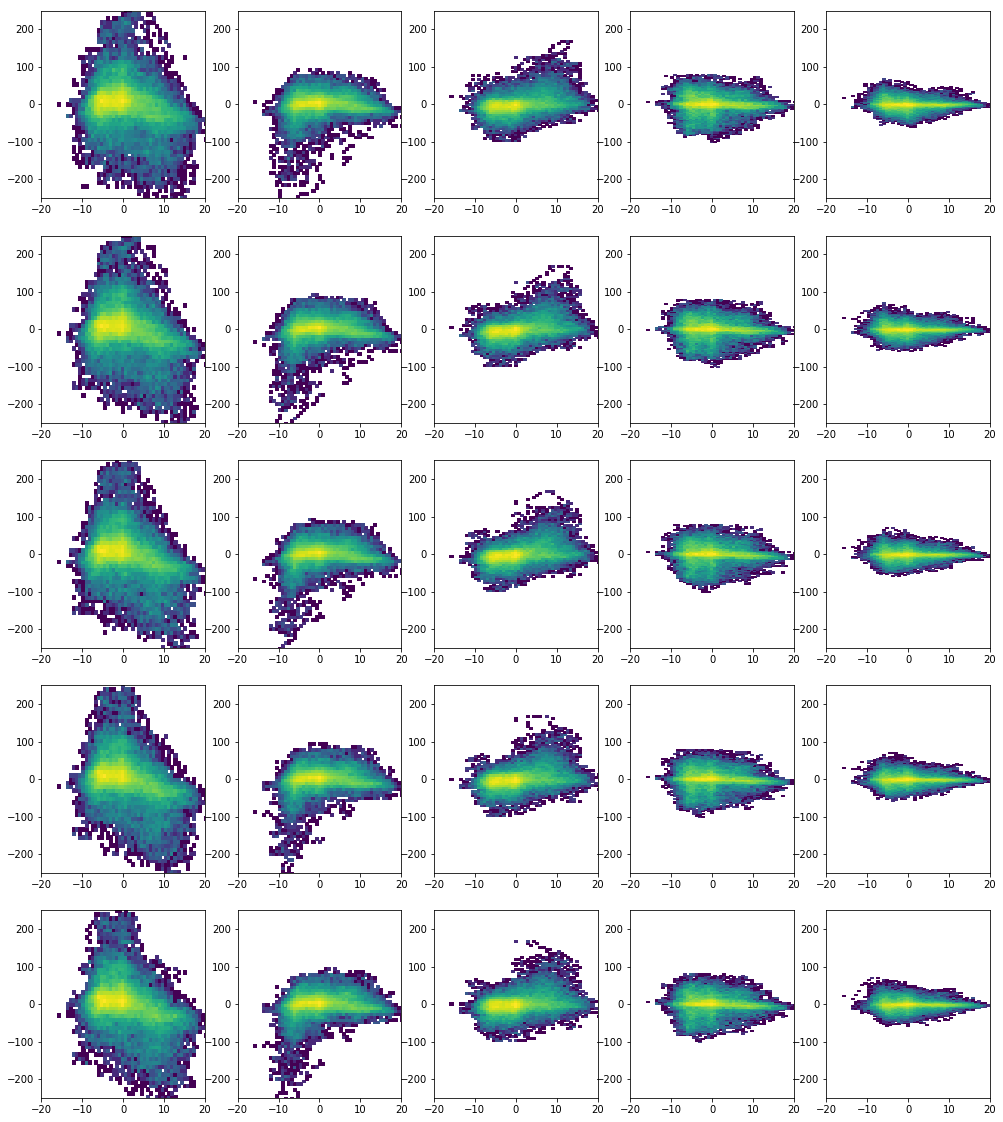

In [113]:
fig, axs = plt.subplots(5, 5, figsize=(17, 20))

for row, lag in zip(axs, [1, 5, 9, 13, 17]):
    for ax, mode in zip(row, range(5)):
        ax.hist2d(mag_axis[:-lag], EOF['B'][lag:, mode], bins=50, norm=mcolors.LogNorm())
        ax.set_xlim([-20, 20])
        ax.set_ylim([-250, 250])